In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
#!pip install ggplot
from math import *
from ggplot import *
from sklearn import datasets, svm, tree, preprocessing, metrics
import sklearn.ensemble as ske
#!pip install tensorflow 
import tensorflow as tf
from tensorflow.contrib import learn as skflow
import seaborn as sns

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\EL MAHDI\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data fields
##### id - a unique identifier for each trip
##### vendor_id - a code indicating the provider associated with the trip record
##### pickup_datetime - date and time when the meter was engaged
##### dropoff_datetime - date and time when the meter was disengaged
##### passenger_count - the number of passengers in the vehicle (driver entered value)
##### pickup_longitude - the longitude where the meter was engaged
##### pickup_latitude - the latitude where the meter was engaged
##### dropoff_longitude - the longitude where the meter was disengaged
##### dropoff_latitude - the latitude where the meter was disengaged
##### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
##### trip_duration - duration of the trip in seconds
Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

In [2]:
taxi_train = pd.read_csv('train.csv')
taxi_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
taxi_train.count()

id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
dtype: int64

with counting number of data in each column, we can see that there is no missing value. all rows are filled with some data.

In [4]:
taxi_train['trip_duration'].mean()
taxi_train['dropoff_longitude'].describe()


count    1.458644e+06
mean    -7.397342e+01
std      7.064327e-02
min     -1.219333e+02
25%     -7.399133e+01
50%     -7.397975e+01
75%     -7.396301e+01
max     -6.133553e+01
Name: dropoff_longitude, dtype: float64

In [5]:
taxi_train['dropoff_latitude'].describe()

count    1.458644e+06
mean     4.075180e+01
std      3.589056e-02
min      3.218114e+01
25%      4.073588e+01
50%      4.075452e+01
75%      4.076981e+01
max      4.392103e+01
Name: dropoff_latitude, dtype: float64

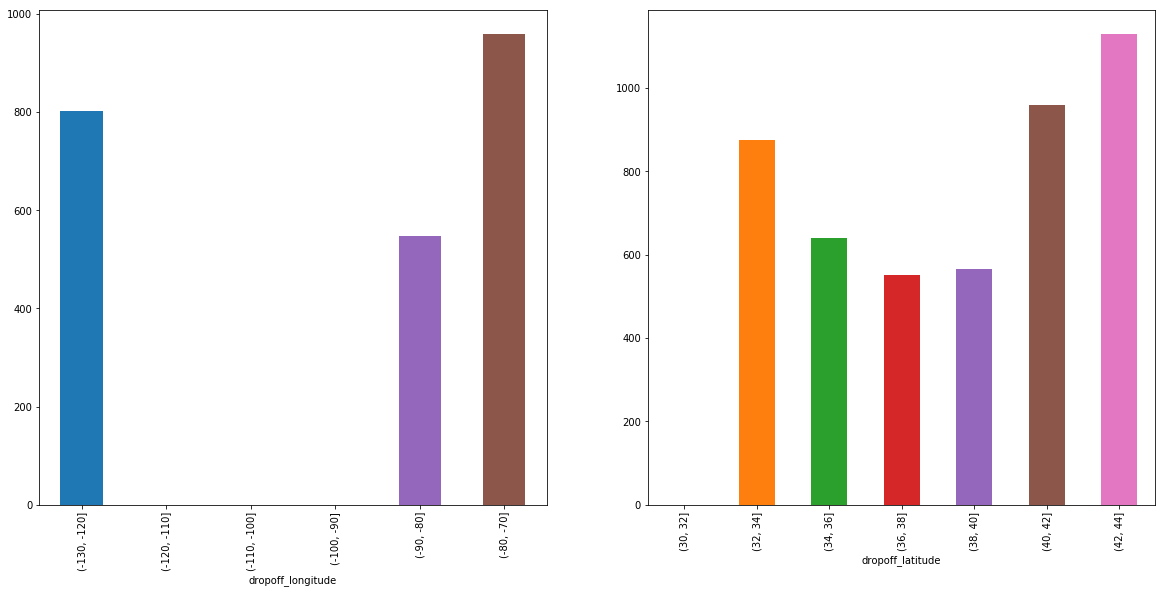

In [6]:
group_by_longitude = pd.cut(taxi_train['dropoff_longitude'], np.arange(-130,-60,10))
group_by_latitude = pd.cut(taxi_train['dropoff_latitude'], np.arange(30,45,2))
longitude_grouping = taxi_train.groupby(group_by_longitude).mean()
latitude_grouping = taxi_train.groupby(group_by_latitude).mean()
#longitude_grouping

plt.figure(1)
ax1=plt.subplot(221)
longitude_grouping['trip_duration'].plot.bar(ax=ax1, figsize=(20, 20))

ax2 = plt.subplot(222)
latitude_grouping['trip_duration'].plot.bar(ax=ax2, figsize=(20, 20))


#taxi_train.groupby(['dropoff_longitude','dropoff_latitude']).mean()

In [7]:
pickup_matrix=pd.concat([taxi_train['pickup_longitude'], taxi_train['pickup_latitude'], taxi_train['trip_duration']], axis=1)

dropoff_matrix=taxi_train[['dropoff_longitude', 'dropoff_latitude']].values
#print(dropoff_matrix)
print(pickup_matrix.head())

   pickup_longitude  pickup_latitude  trip_duration
0        -73.982155        40.767937            455
1        -73.980415        40.738564            663
2        -73.979027        40.763939           2124
3        -74.010040        40.719971            429
4        -73.973053        40.793209            435


In [8]:
#piv = pd.pivot_table(pickup_matrix, index='pickup_longitude', columns='pickup_latitude', values='trip_duration')
#ax=sns.heatmap(piv, square=True)


In [9]:
#boxplot1=taxi_train.boxplot(column=['pickup_longitude'], by=['pickup_latitude'])
#boxplot1


#ggplot(taxi_train, aes(x='pickup_latitude', y='pickup_longitude')) + geom_boxplot()
display(taxi_train['pickup_latitude'].describe())
display(taxi_train['pickup_longitude'].describe())

count    1.458644e+06
mean     4.075092e+01
std      3.288119e-02
min      3.435970e+01
25%      4.073735e+01
50%      4.075410e+01
75%      4.076836e+01
max      5.188108e+01
Name: pickup_latitude, dtype: float64

count    1.458644e+06
mean    -7.397349e+01
std      7.090186e-02
min     -1.219333e+02
25%     -7.399187e+01
50%     -7.398174e+01
75%     -7.396733e+01
max     -6.133553e+01
Name: pickup_longitude, dtype: float64

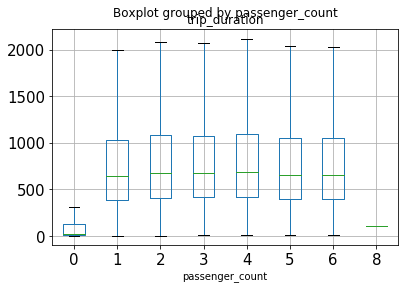

In [10]:
taxi4=taxi_train.loc[(taxi_train['pickup_latitude']>40.65) & (taxi_train['pickup_latitude']<40.87) & 
                     (taxi_train['pickup_longitude']>-74.025) & (taxi_train['pickup_longitude']<-73.8), 
                     ['vendor_id','passenger_count','store_and_fwd_flag','trip_duration']]
#'pickup_longitude','pickup_latitude','dropoff_latitude','pickup_longitude',
#pd.plotting.scatter_matrix(taxi4, alpha=0.8, figsize=(6,6))

taxi4.boxplot(column='trip_duration', by='passenger_count', grid=True, fontsize=15, showfliers=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000250B27D9358>]],
      dtype=object)

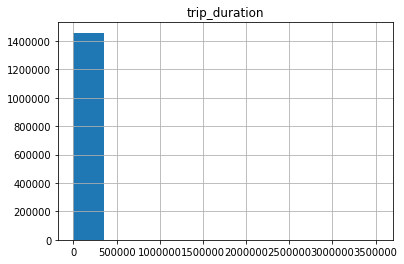

In [11]:
taxi_train.hist(column='trip_duration')

The variable trip_duration is right skewed with very long tail. We will therefore take the log to normalise the distribution. Let’s check the new plot:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000250B2851278>]],
      dtype=object)

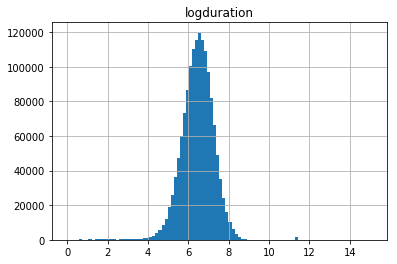

In [12]:
taxi_train2=taxi_train.copy(deep=False)
taxi_train2['logduration']=np.log(taxi_train2['trip_duration'])
taxi_train2.hist(column='logduration', bins=100)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000250B2945B00>,
      dtype=object)

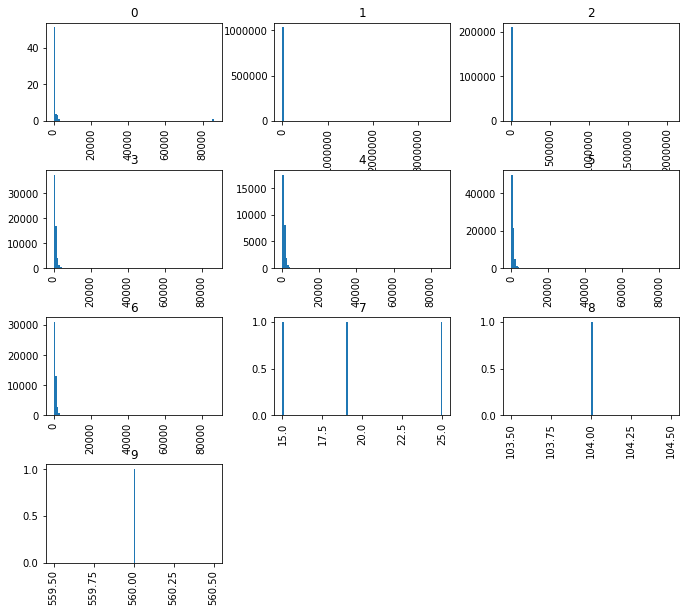

In [13]:
taxi_train.hist(column='trip_duration',by='passenger_count', figsize=(11,10), bins=100)

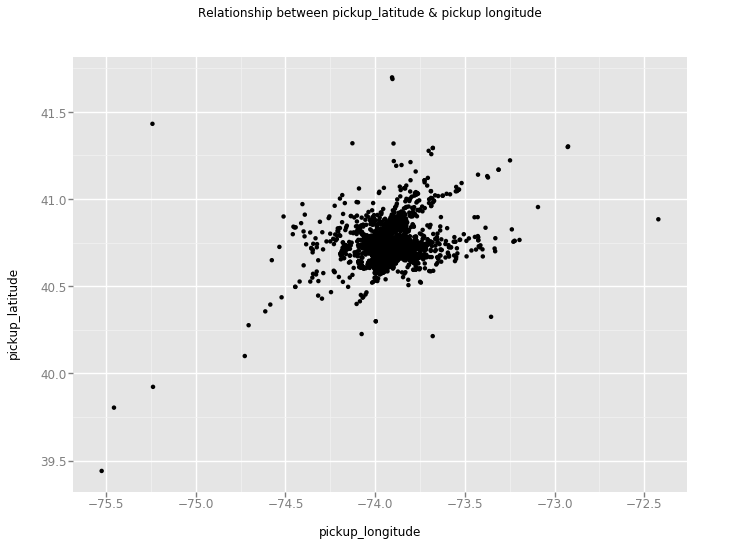

<ggplot: (-9223371877753233278)>

In [14]:
taxi1=taxi_train.loc[(taxi_train['pickup_latitude']>39) & (taxi_train['pickup_latitude']<42) & 
                     (taxi_train['pickup_longitude']>-76) & (taxi_train['pickup_longitude']<-72), 
                     ['pickup_latitude','pickup_longitude']]
fig = (
    ggplot(taxi1,aes(x = 'pickup_longitude', y = 'pickup_latitude'))+
    geom_point() +
    ggtitle("Relationship between pickup_latitude & pickup longitude") 
)
fig

pickup_latitude     1458040
pickup_longitude    1458040
dtype: int64

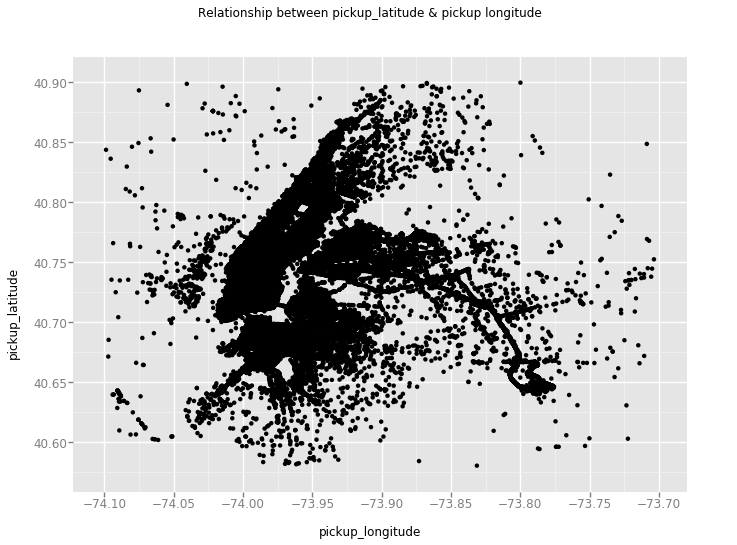

<ggplot: (159103813668)>

In [15]:
taxi2=taxi_train.loc[(taxi_train['pickup_latitude']>40.58) & (taxi_train['pickup_latitude']<40.9) & 
                     (taxi_train['pickup_longitude']>-74.1) & (taxi_train['pickup_longitude']<-73.7), 
                     ['pickup_latitude','pickup_longitude']]
fig = (
    #ggplot(taxi2,aes(x = 'pickup_latitude', y = 'pickup_longitude'))+
    ggplot(taxi2,aes(x = 'pickup_longitude', y = 'pickup_latitude'))+
    geom_point() +
    ggtitle("Relationship between pickup_latitude & pickup longitude")
    
)
display(taxi2.count())
display(fig)


pickup_latitude     1424681
pickup_longitude    1424681
dtype: int64

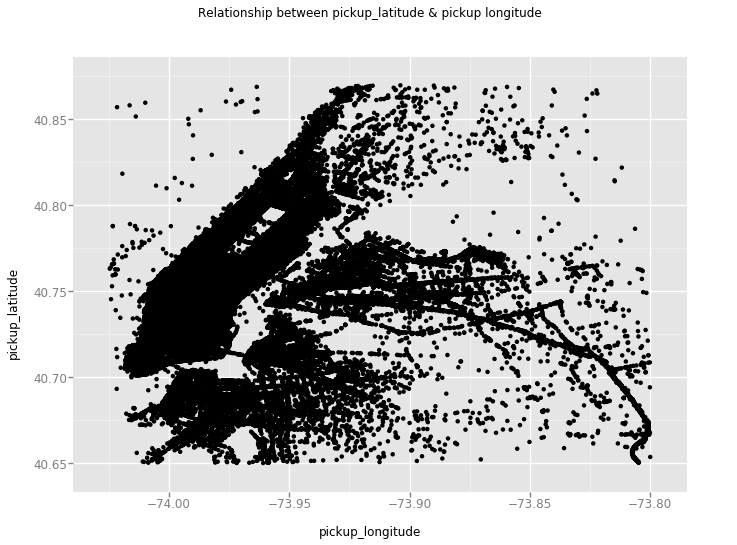

<ggplot: (159103824588)>

In [16]:
taxi3=taxi_train.loc[(taxi_train['pickup_latitude']>40.65) & (taxi_train['pickup_latitude']<40.87) & 
                     (taxi_train['pickup_longitude']>-74.025) & (taxi_train['pickup_longitude']<-73.8), 
                     ['pickup_latitude','pickup_longitude']]
fig = (
    
    ggplot(taxi3,aes(x = 'pickup_longitude', y = 'pickup_latitude'))+
    geom_point() +
    ggtitle("Relationship between pickup_latitude & pickup longitude")
    
)
display(taxi3.count())
display(fig)

# Etude par Vendor

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000250891B2F28>,
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025089293F98>,
      dtype=object)

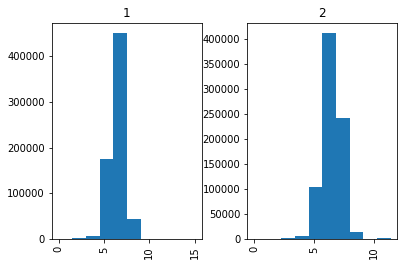

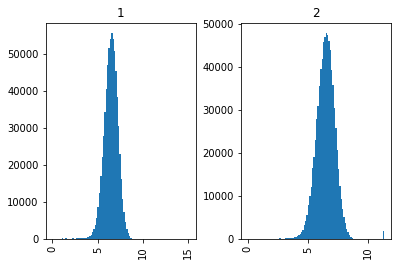

In [32]:
taxi_train2['logduration']=np.log(taxi_train2['trip_duration'])
display(taxi_train2.hist(column='logduration', by='vendor_id',bins=10))
display(taxi_train2.hist(column='logduration', by='vendor_id',bins=100))


### Some counts
#### The number of observations in the dataset from each of the two companies i.e. 1 and 2, seems to be comparable

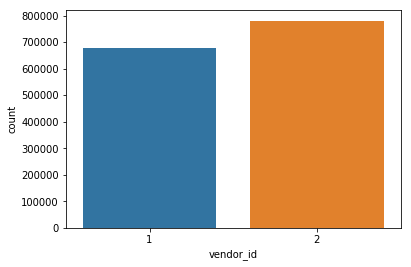

In [17]:
sns.countplot(data=taxi_train, x='vendor_id')

In [18]:
display("number of records from company 1:",taxi_train[taxi_train['vendor_id']==1]['vendor_id'].count())
display("number of records from company 2:",taxi_train[taxi_train['vendor_id']==2]['vendor_id'].count())

'number of records from company 1:'

678342

'number of records from company 2:'

780302

### mean of trip_duration by vendor_id

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
vendor_id,,,,,,
1,1.259402,-73.974081,40.750859,-73.973532,40.751626,845.438244
2,2.016720,-73.972969,40.750974,-73.973315,40.751950,1058.643164


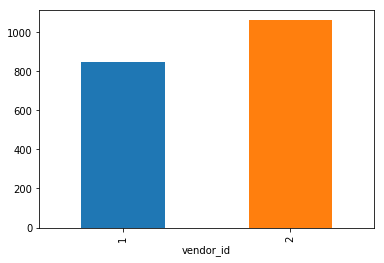

In [19]:
vendor_grouping=taxi_train.groupby('vendor_id').mean()
display(vendor_grouping)
vendor_grouping['trip_duration'].plot.bar()


### Distribution of the number of passengers across the vendor_id variables 1 and 2

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000250E0E77AC8>,
      dtype=object)

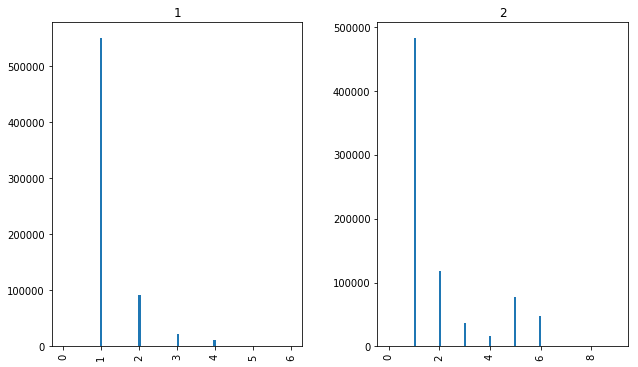

In [20]:
taxi_train.hist(column='passenger_count',by='vendor_id', figsize=(10,6), bins=100)

Text(0.5,1,'company 2')

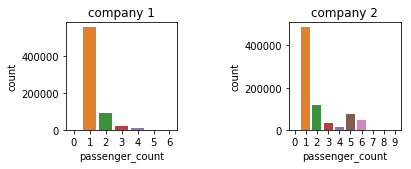

In [21]:
plt.figure(2)
plt.subplots_adjust(wspace = 1, hspace=0.01)
ax1=plt.subplot(221)
sns.countplot(ax=ax1, x="passenger_count", data=taxi_train[taxi_train["vendor_id"] == 1]).set_title('company 1')
ax2=plt.subplot(222)
sns.countplot(ax=ax2, x="passenger_count", data=taxi_train[taxi_train["vendor_id"] == 2]).set_title('company 2')

### Trip duration against number of passengers split by the vendor_id

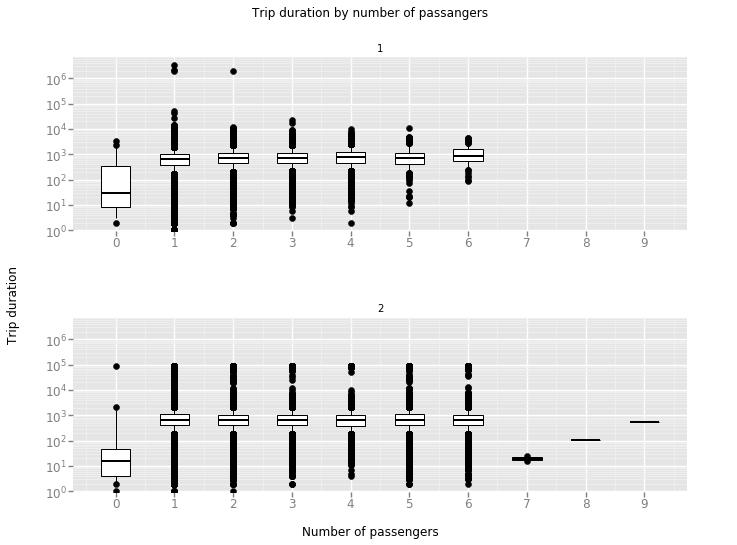

<ggplot: (159149619022)>

In [22]:
fig2=(ggplot(taxi_train, aes(x = 'passenger_count', y = 'trip_duration'))+
    geom_boxplot() +
    scale_y_log()+
    facet_wrap("vendor_id")+
    scale_y_continuous(name='Trip duration')+
    scale_x_continuous(name='Number of passengers')+
    ggtitle("Trip duration by number of passangers") 
)
fig2

From the plots there appears to be some correlation between the passenger count and trip duration for vendor 1. We  see 0 passenger number taxi trips?! We can remove these from our model.
For vendor 1, when number of passengers is above 6 we can't rely on it to predict the trip duration. On the other hand, for vendor 2, we can give an estimation of the trip duration when nb of passengers > 6. However, vendor id 2 is responsible for the outliers more than vendor 1.
Generally speaking, it appears to be a little (weak) correlation between vendor_id and trip duration.

### Pickup datetime and Trip duration

In [23]:
from datetime import *


In [24]:
## pickup_datetime in taxi_train isnt a datetime object it s a serie object we need to convert it to a datetime.
taxi_train2['pickup_datetime']=pd.to_datetime(taxi_train2['pickup_datetime'])
## now that s converted we can select the hour month year ....
#display(taxi_train2['pickup_datetime'].head())
#display(taxi_train2['pickup_datetime'].dt.hour.head())
### we create a column for pickup hours
taxi_train2['pickup_hour']=taxi_train2['pickup_datetime'].dt.hour
display(taxi_train2['pickup_datetime'].head())
display(taxi_train2['pickup_hour'].head())
display(taxi_train2['pickup_datetime'].dt.year.unique())

## create a Day_Hour column
taxi_train2['pickup_DayHour']=taxi_train2['pickup_datetime'].dt.strftime('%d,%H')
display(taxi_train2['pickup_DayHour'].head())

0   2016-03-14 17:24:55
1   2016-06-12 00:43:35
2   2016-01-19 11:35:24
3   2016-04-06 19:32:31
4   2016-03-26 13:30:55
Name: pickup_datetime, dtype: datetime64[ns]

0    17
1     0
2    11
3    19
4    13
Name: pickup_hour, dtype: int64

array([2016], dtype=int64)

0    14,17
1    12,00
2    19,11
3    06,19
4    26,13
Name: pickup_DayHour, dtype: object

#### plot with log(trip duration) by pickup Hour

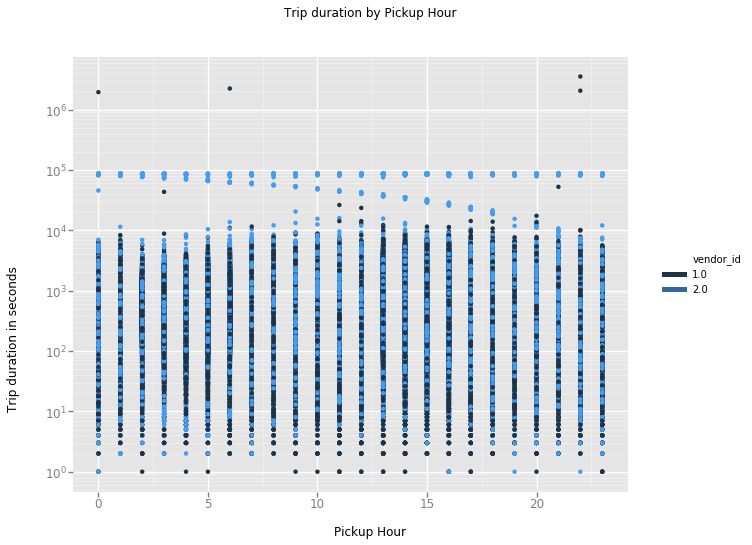

<ggplot: (-9223371877806447086)>

In [25]:
fig3=(ggplot(taxi_train2, aes(x = 'pickup_hour', y = 'trip_duration', color='vendor_id'))+
    geom_point() +
    scale_y_log()+
    #facet_wrap("vendor_id")+
    scale_y_continuous(name='Trip duration in seconds')+
    scale_x_continuous(name='Pickup Hour')+
    ggtitle("Trip duration by Pickup Hour") 
)
fig3

#### plot without the log(trip_duration) by pickup Hour

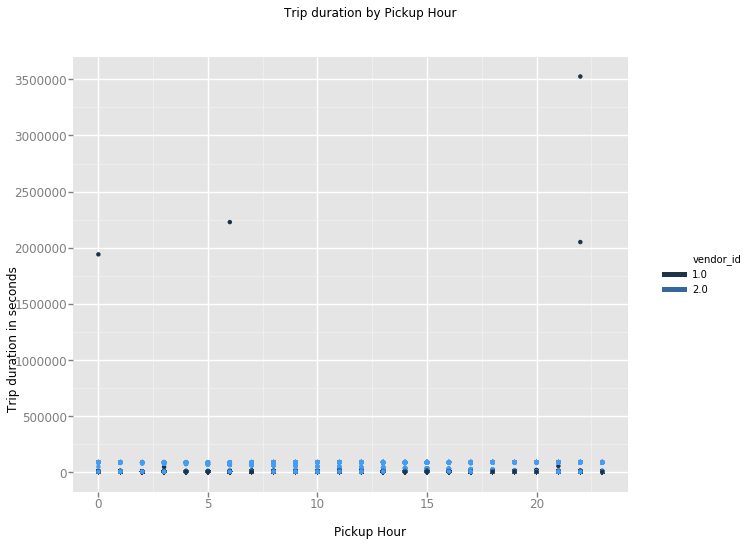

<ggplot: (-9223371877805441399)>

In [26]:
fig4=(ggplot(taxi_train2, aes(x = 'pickup_hour', y = 'trip_duration', color='vendor_id'))+
    geom_point() +
    #scale_y_log()+
    #facet_wrap("vendor_id")+
    scale_y_continuous(name='Trip duration in seconds')+
    scale_x_continuous(name='Pickup Hour')+
    ggtitle("Trip duration by Pickup Hour") 
)
fig4

#### plot without the log(trip_duration) by pickup DayHour

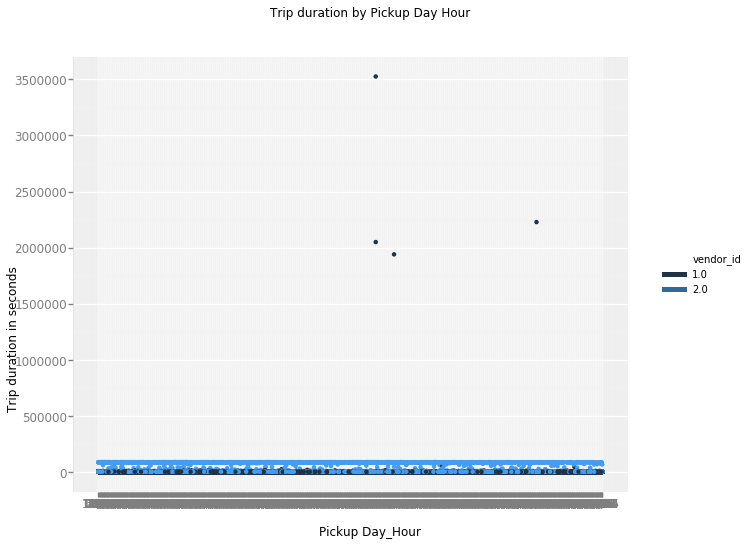

<ggplot: (-9223371877805441294)>

In [27]:
fig5=(ggplot(taxi_train2, aes(x = 'pickup_DayHour', y = 'trip_duration', color='vendor_id'))+
    geom_point() +
    #scale_y_log()+
    #facet_wrap("vendor_id")+
    scale_y_continuous(name='Trip duration in seconds')+
    scale_x_continuous(name='Pickup Day_Hour')+
    ggtitle("Trip duration by Pickup Day Hour") 
)
fig5

#### plot with the log(trip_duration) by pickup DayHour

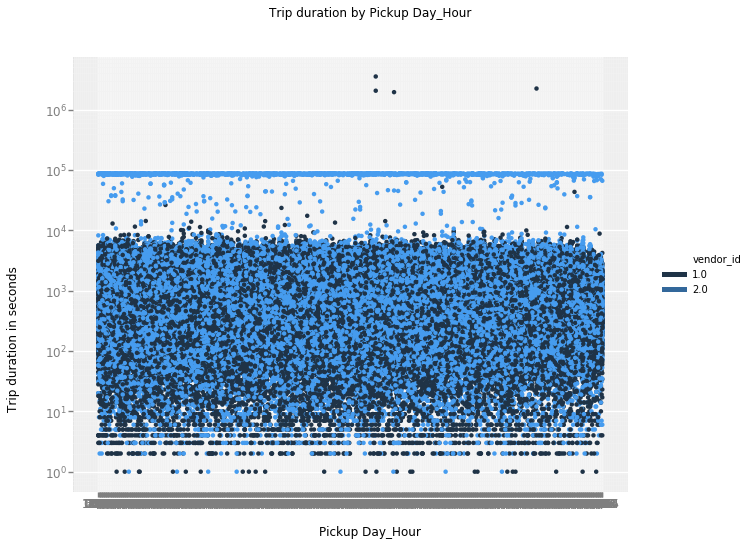

<ggplot: (159049425770)>

In [28]:
fig6=(ggplot(taxi_train2, aes(x = 'pickup_DayHour', y = 'trip_duration', color='vendor_id'))+
    geom_point() +
    scale_y_log()+
    #facet_wrap("vendor_id")+
    scale_y_continuous(name='Trip duration in seconds')+
    scale_x_continuous(name='Pickup Day_Hour')+
    ggtitle("Trip duration by Pickup Day_Hour") 
)
fig6

#### plot with the log(trip_duration) by pickup DayHour

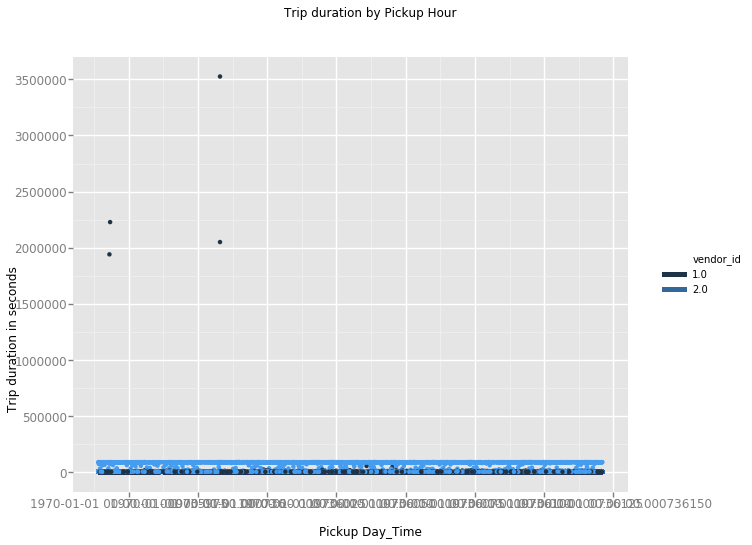

<ggplot: (159081666182)>

In [29]:
fig7=(ggplot(taxi_train2, aes(x = 'pickup_datetime', y = 'trip_duration', color='vendor_id'))+
    geom_point() +
    #scale_y_log()+
    #facet_wrap("vendor_id")+
    scale_y_continuous(name='Trip duration in seconds')+
    scale_x_continuous(name='Pickup Day_Time')+
    ggtitle("Trip duration by Pickup Hour") 
)
fig7

Based on this plot there appear to be outliers scattered above a threshold 20,000 second duration by vendor 1

In [33]:
from math import *

## Convert Lat/Long to X/Y cartesian coordinates

In [34]:
#Latitude and Longitude to cartesian cordindates converesion
# Assuming Earth as sphere not ellipsoid 
def cartesian_x(lat,lon):
    lat=radians(lat)
    lon=radians(lon)
    R=6371.0
    x = R * cos(lat) * cos(lon)
    return x
def cartesian_y(lat,lon):
    lat=radians(lat)
    lon=radians(lon)
    R=6371.0
    y = R * cos(lat) * sin(lon)
    return y
# extracting cartesian x,y cordinates form latitude and longitude
taxi_train2['x1']=[cartesian_x(i,j) for i,j in zip(taxi_train2['pickup_latitude'],taxi_train2['pickup_longitude'])]
taxi_train2['y1']=[cartesian_y(i,j) for i,j in zip(taxi_train2['pickup_latitude'],taxi_train2['pickup_longitude'])]
taxi_train2['x2']=[cartesian_x(i,j) for i,j in zip(taxi_train2['dropoff_latitude'],taxi_train2['dropoff_longitude'])]
taxi_train2['y2']=[cartesian_y(i,j) for i,j in zip(taxi_train2['dropoff_latitude'],taxi_train2['dropoff_longitude'])]


In [73]:
def euclidean_distance(a1,b1,a2,b2):
    dist=np.sqrt((a2-a1)**2+(b2-b1)**2)
    return dist
    
taxi_train2['distance1']=[euclidean_distance(i,j,k,l) for i,j,k,l in zip(taxi_train2['x1'], taxi_train2['y1'],taxi_train2['x2'], taxi_train2['y2'])]
taxi_train2[['x1','y1','x2','y2','distance1', 'id', 'trip_duration']].head()

,x1,y1,x2,y2,distance1,id,trip_duration
0,1331.434577,-4637.812000,1332.899879,-4637.567460,1.485567,id2875421,455
1,1332.163782,-4639.820928,1330.768000,-4640.780951,1.694063,id2377394,663
2,1331.767887,-4638.018298,1330.715070,-4642.385731,4.492538,id3858529,2124
3,1330.136170,-4641.805883,1330.220426,-4642.781602,0.979350,id3504673,429
4,1331.664551,-4635.836280,1331.889410,-4636.579512,0.776502,id2181028,435


count    1.458644e+06
mean     2.806154e+00
std      3.735756e+00
min      0.000000e+00
25%      9.837532e-01
50%      1.659195e+00
75%      2.979554e+00
max      8.980872e+02
Name: distance1, dtype: float64

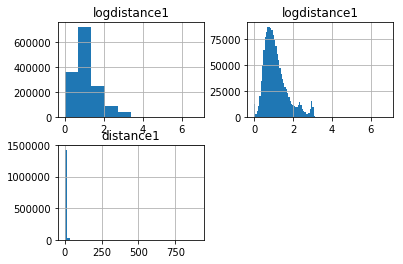

In [100]:
taxi_train2['logdistance1']=np.log(taxi_train2['distance1']+1)  ## we add 1 because there is some distances equal to 0 (pickup=dropoff)

ax1=plt.subplot(221)
taxi_train2.hist(ax=ax1,column='logdistance1', bins=10)

ax2=plt.subplot(222)
taxi_train2.hist(ax=ax2,column='logdistance1', bins=100)

ax3=plt.subplot(223)
taxi_train2.hist(ax=ax3,column='distance1', bins=55)

taxi_train2['distance1'].describe()

vendor_id             5897
store_and_fwd_flag    5897
pickup_latitude       5897
pickup_longitude      5897
dropoff_latitude      5897
dropoff_longitude     5897
distance1             5897
logdistance1          5897
trip_duration         5897
dtype: int64

,vendor_id,store_and_fwd_flag,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance1,logdistance1,trip_duration
246,2,N,40.768963,-73.981819,40.768963,-73.981819,0.0,0.0,227
291,2,N,40.775661,-73.959068,40.775661,-73.959068,0.0,0.0,1109
407,2,N,40.687336,-73.808487,40.687336,-73.808487,0.0,0.0,947
702,1,N,40.647041,-73.786720,40.647041,-73.786720,0.0,0.0,580
1620,1,N,40.816853,-74.209854,40.816853,-74.209854,0.0,0.0,27


Text(0.5,1,'trip distance = 0')

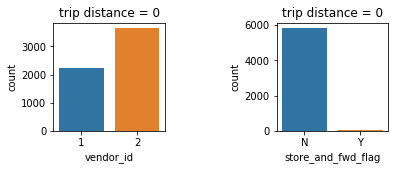

In [102]:
## check out the  case when the pickup position equals the dropoff position
display(taxi_train2.loc[taxi_train2['distance1']==0,['vendor_id','store_and_fwd_flag','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','distance1','logdistance1', 'trip_duration']].count())
## count=5897 rows
display(taxi_train2.loc[taxi_train2['distance1']==0,['vendor_id','store_and_fwd_flag','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','distance1','logdistance1', 'trip_duration']].head())

#taxi_train2.loc[taxi_train2['distance1']==0,['vendor_id']].mean()

plt.figure(5)
plt.subplots_adjust(wspace = 1, hspace=0.01)
ax1=plt.subplot(221)
sns.countplot(ax=ax1, x="vendor_id", data=taxi_train2[taxi_train2["distance1"] == 0]).set_title('trip distance = 0')

ax2=plt.subplot(222)
sns.countplot(ax=ax2, x="store_and_fwd_flag", data=taxi_train2[taxi_train2["distance1"] == 0]).set_title('trip distance = 0')